<a href="https://colab.research.google.com/github/Shopping-Yuan/ML2021HW/blob/Shopping_vscode_branch/HW6/HW06_modified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Hw6
###Part 0 : setting & install package
###Part 1 : data cleaning
###Part 2 : build model
###Part 3 : training and validation
###Part 4 : inference

###setting

In [2]:
setting = {
# information of the path of dataset
"documents" : {
    "workspace_dir" : "/content/drive/MyDrive/HW6_data",
    "log_doc_path" : "/log",
    "ckpt_file_path" : "/model",
    "model_temp_save_path" : "/temporary_model",
    "out_doc_path" : "/sn_gan_out",
},
"dataset" : {
},
"dataloader" : {
    "batch_size" : 64,
    "num_workers" : 2,
    "shuffle" : True,
},
# model setting
"model" : {
    "sample_number" : 100,
    "generator_in_dimension" : 100
},
# setting in training and validation process ,
# including optimization setting.
"training_hparas" : {
    "total_epoch" : 1, # 50
    "generator_step" : 5, # 5
    "temp_save_epoch" : 1,
    "wgan_clip_value" : 0.01,
    },
"generator_optimizer" : {
    "lr" : 1e-4,
    "betas" : (0.5, 0.999)
    },
"discriminator_optimizer" : {
    "lr" : 1e-4,
    "betas" : (0.5, 0.999)
    },
}

###install package

In [3]:
!pip install qqdm
!pip install torchinfo

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.1 MB/s eta 0:00:00
  Created wheel for qqdm: filename=qqdm-0.0.7-py3-none-any.whl size=6468 sha256=61cd46226324d0f0ff4d63ef21cb8c156f633dd82b5613d78e1047e525922ffb
  Stored in directory: /root/.cache/pip/wheels/40/1a/56/5dccdea123a172661eb65c8c29fde4567dbda2b72b5fc5893a
Successfully built qqdm


In [4]:
# step 1 : download dataset from drive to google colab
# original dataset is in "https://mega.nz/#!vEcTCISJ!3Rw0eHTZWPpdHBTbQEqBDikDEdFPr7fI8WxaXK9yZ9U"

workspace_dir = "/content/drive/MyDrive/HW6_data"
rawdata_file_path = workspace_dir + "/crypko_data.zip"
unzip_path = "/content/unzip_image/"

# mount drive
from google.colab import drive
drive_path = "/content/drive"
drive.mount(drive_path)

# step 2 : unzip dataset
import zipfile
with zipfile.ZipFile(rawdata_file_path, 'r') as zip_f:
    zip_f.extractall(unzip_path)

Mounted at /content/drive


In [5]:
import random

import torch
import numpy as np


def seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [6]:

import torch
import os
import glob
import torchvision
from torchvision.transforms import v2
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt
class CrypkoDataset(Dataset):
  def __init__(self):
    self.imgs = glob.glob(os.path.join(unzip_path,"faces","*"))

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, index):
    img = torchvision.io.read_image(self.imgs[index])
    return self.crypko_transform(img)
    # return img

  def crypko_transform(self,img):
    compose = [
          v2.ToPILImage(),
          v2.Resize((64, 64)),
          v2.ToTensor(),
          v2.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
          ]
    transform =  v2.Compose(compose)
    return transform(img)

def get_dataloader(dataset,batch_size,shuffle,num_workers):
  return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


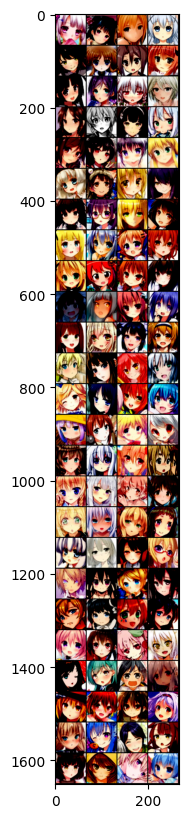

In [7]:
dataset = CrypkoDataset()
images = [dataset[i] for i in range(100)]
# print(images[0][0][0][0],type(images[0][0][0][0].item()))
grid_img = torchvision.utils.make_grid(images, nrow=4)
plt.figure(figsize=(10,10))
out = grid_img.permute(1, 2, 0)
plt.imshow(out)
plt.show()

# from qqdm.notebook import qqdm
# loader = DataLoader(dataset, batch_size=12, shuffle=True, num_workers=0)
# step = 0
# for data in qqdm(loader):
#   if step<2:
#     images = [data[i] for i in range(10)]
#     grid_img = torchvision.utils.make_grid(images, nrow=4)
#     plt.figure(figsize=(10,10))
#     out = grid_img.permute(1, 2, 0)
#     plt.imshow(out)
#     plt.show()
#   step += 1

In [37]:
import torch.nn as nn
def weights_init(layer):
    classname = layer.__class__.__name__
    # if hasattr(layer,"weight"):
    #   print(classname,layer.weight.shape)
    if classname.find('Conv') != -1:
        if hasattr(layer,"weight"):
          layer.weight.data.normal_(0.0, 0.02)
        elif hasattr(layer,"w_without_sn"):
          layer.w_without_sn.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        if hasattr(layer,"weight"):
          layer.weight.data.normal_(1.0, 0.02)
        elif hasattr(layer,"w_without_sn"):
          layer.w_without_sn.data.normal_(1.0, 0.02)
        layer.bias.data.fill_(0)
class Spectral_Normalization(nn.Module):
    def __init__(self,layer,eps = 1e-12,power_iteration = 1):
        super().__init__()
        self.layer = layer
        self.classname = self.layer.__class__.__name__
        self.eps = eps
        self.power_iteration = power_iteration
        self.set_sn_weight()
    """
    in forward process : spectral normalization weight is used
    but in backward process : calculate the gradient of original weight
    (i.e. weight without spectral normalization)

    So the data of the original weight must be keep as a new "parameter",
    then the "parameter" "weight"(whose data is the original weight) must be delete,
    and spectral normalization weight must be add as "attribute"(not "parameter") named "weight".

    Since spectral normalization weight is named "weight" but not a "parameter",
    it will be used to compute the output in forward process.(named "weight")
    But its gradient will not calculated in backward process.(not a "parameter")

    On the contrary, since the original weight is save as a new "parameter",
    the gradient of original weight is calculated in backward process,
    so the parameter (with respected to original weight) will be updated.

    In next forward process, with the updated parameter (with respected to original weight)
    the new spectral normalization weight can be computed.
    Reset the attribute "weight"(with respected to new spectral normalization weight),
    the new output of can be computed.
    """
    def set_sn_weight(self):
        # save weight to another parameter
        weight_without_sn = getattr(self.layer, "weight").data
        self.layer.register_parameter(self.classname+"w_without_sn", nn.Parameter(weight_without_sn))
        # delete the original weight
        del self.layer._parameters["weight"]

        # to computed spectral normalization weight,
        # u and v (SVD matrixs of weight) must be setting
        # step 1 : reshape weight to 2D-matrix to produce u,v
        weight_2D = weight_without_sn.view(weight_without_sn.shape[0],-1)

        # step 2 : using weight_2D to initialize u and v
        u = torch.empty(weight_2D.shape[0]).normal_(0, 1)
        v = torch.mv(torch.transpose(weight_2D, 0, 1),u)

        # step 3 : u,v are saved as buffer for updating spectral normalization weight
        self.layer.register_buffer(self.classname+"_u", u)
        self.layer.register_buffer(self.classname+"_v", v)

    # update_sn_weight is the function call in forward process
    # spectral normalization weight is computed/updated here
    def update_sn_weight(self):
        # step 4 : get u,v ,get and reshape original weight
        u = getattr(self.layer, self.classname + "_u")
        v = getattr(self.layer, self.classname + "_v")

        weight_without_sn = getattr(self.layer, self.classname+"w_without_sn")
        w_shape = weight_without_sn.shape
        weight_2D = weight_without_sn.view(w_shape[0],-1)

        # step 5 : using power iteration to update u,v

        for times in range(self.power_iteration):
          v = torch.mv(torch.transpose(weight_2D, 0, 1),u)
          u = torch.mv(weight_2D,v)
          u.data = u.data/(u.data.norm() + self.eps)
          v.data = v.data/(v.data.norm() + self.eps)

        # step 6 : compute spectral normalization weight using u,v
        w_max_sv = u@(torch.mv(weight_2D,v)).data
        w_sn = weight_without_sn / w_max_sv
        # step 7 : reshape spectral normalization weight(shape equal to origin weight)
        w_sn = w_sn.view(w_shape)

        # add new weight(spectral normalization weight) as attribute back to the layer
        setattr(self.layer, "weight", w_sn)

    def forward(self,x):
      self.update_sn_weight()
      return(self.layer.forward(x))


class Print(nn.Module):
    def __init__(self):
      super().__init__()
    def forward(self,x):
      print(x.shape)
      return x
class Generator(nn.Module):
    def __init__(self, in_dim, dim=64):
      super().__init__()
      self.indim = in_dim
      self.dim = dim
      def dconv_bn_relu(in_dim, out_dim):
            return nn.Sequential(
                nn.ConvTranspose2d(in_dim, out_dim, 5, 2,
                          padding=2, output_padding=1, bias=False),
                nn.BatchNorm2d(out_dim),
                nn.ReLU())
      self.l1 = nn.Sequential(
            nn.Linear(self.indim, self.dim * 8 * 4 * 4, bias=False),
            nn.BatchNorm1d(self.dim * 8 * 4 * 4),
            nn.ReLU())
      self.l2_5 = nn.Sequential(
            dconv_bn_relu(self.dim * 8, self.dim * 4),
            dconv_bn_relu(self.dim * 4, self.dim * 2),
            dconv_bn_relu(self.dim * 2, self.dim),
            nn.ConvTranspose2d(self.dim, 3, 5, 2, padding=2, output_padding=1),
            nn.Tanh()
        )
      self.apply(weights_init)
    def forward(self,x):
      y = self.l1(x)
      batch_size = y.size(0)
      dconv_dim = self.dim*8
      y = y.view(batch_size,dconv_dim,4,4)
      y = self.l2_5(y)
      return y

class Discriminator(nn.Module):
    """
    Input shape: (N, 3, 64, 64)
    Output shape: (N, )
    """
    def __init__(self, in_dim, dim=64):
        super().__init__()

        def conv_bn_lrelu(in_dim, out_dim):
            return nn.Sequential(
                Spectral_Normalization(nn.Conv2d(in_dim, out_dim, 5, 2, 2)),
                Spectral_Normalization(nn.BatchNorm2d(out_dim)),
                nn.LeakyReLU(0.2))

        """ Medium: Remove the last sigmoid layer for WGAN. """
        self.ls = nn.Sequential(
            Spectral_Normalization(nn.Conv2d(in_dim, dim, 5, 2, 2)),
            nn.LeakyReLU(0.2),
            conv_bn_lrelu(dim, dim * 2),
            conv_bn_lrelu(dim * 2, dim * 4),
            conv_bn_lrelu(dim * 4, dim * 8),
            Spectral_Normalization(nn.Conv2d(dim * 8, 1, 4)),
            # nn.Sigmoid(),
        )
        self.apply(weights_init)

    def forward(self, x):
        y = self.ls(x)
        y = y.view(-1)
        return y

In [29]:
import torch
from torchinfo import summary
model_G = Generator(100)
# print(summary(model_G,(32,100)))
# input = torch.rand(32,100)
# print(model_G(input).shape)
model_D = Discriminator(3)
print(model_D.state_dict().keys())

# print(summary(model_D,(32,3,64,64)))
# input = torch.rand(32,3,64,64)
# print(model_D(input).shape)

odict_keys(['ls.0.layer.bias', 'ls.0.layer.Conv2dw_without_sn', 'ls.0.layer.Conv2d_u', 'ls.0.layer.Conv2d_v', 'ls.2.0.layer.bias', 'ls.2.0.layer.Conv2dw_without_sn', 'ls.2.0.layer.Conv2d_u', 'ls.2.0.layer.Conv2d_v', 'ls.2.1.layer.bias', 'ls.2.1.layer.BatchNorm2dw_without_sn', 'ls.2.1.layer.running_mean', 'ls.2.1.layer.running_var', 'ls.2.1.layer.num_batches_tracked', 'ls.2.1.layer.BatchNorm2d_u', 'ls.2.1.layer.BatchNorm2d_v', 'ls.3.0.layer.bias', 'ls.3.0.layer.Conv2dw_without_sn', 'ls.3.0.layer.Conv2d_u', 'ls.3.0.layer.Conv2d_v', 'ls.3.1.layer.bias', 'ls.3.1.layer.BatchNorm2dw_without_sn', 'ls.3.1.layer.running_mean', 'ls.3.1.layer.running_var', 'ls.3.1.layer.num_batches_tracked', 'ls.3.1.layer.BatchNorm2d_u', 'ls.3.1.layer.BatchNorm2d_v', 'ls.4.0.layer.bias', 'ls.4.0.layer.Conv2dw_without_sn', 'ls.4.0.layer.Conv2d_u', 'ls.4.0.layer.Conv2d_v', 'ls.4.1.layer.bias', 'ls.4.1.layer.BatchNorm2dw_without_sn', 'ls.4.1.layer.running_mean', 'ls.4.1.layer.running_var', 'ls.4.1.layer.num_batches_

In [ ]:
# print(list(setting["discriminator_optimizer"].values())[0])

In [32]:
def GP_term(G_out,ref,D,l=10):
  epison = torch.rand((1)).item()
  G_out_detach = G_out.detach()
  ref_detach = ref.detach()
  random_point = epison*ref_detach + (1-epison)*G_out_detach
  random_point.requires_grad = True
  D.zero_grad()
  for p in D.parameters():
    p.requires_grad = False
  diff = D(random_point)
  diff.backward(torch.ones(diff.size(0)))
  grad = random_point.grad
  for p in D.parameters():
    p.requires_grad = True
  grad_flat = grad.view(32,-1)
  return(l*torch.square(torch.torch.norm(grad_flat,dim = -1)-1))

# from torchinfo import summary
# dataset = CrypkoDataset()
# ref = torch.stack([dataset[i] for i in range(32)])
# print(ref.shape)
# model_G = Generator(100)
# G_input = torch.rand(32,100)
# G_out = model_G(input)
# print(model_G(input).shape)
# model_D = Discriminator(3)
# GP_term(G_out,ref,model_D,l=10).shape

In [33]:
import os
from qqdm.notebook import qqdm
def train_val(documents,dataset,dataloader,model,training_hparas,
        generator_optimizer,discriminator_optimizer):

  #doc paths
  paths = list(documents.values())
  workspace_dir, log_doc_path, ckpt_file_path, model_temp_save_path, out_doc_path = paths
  print(workspace_dir)
  for path in paths[1:]:
    full_path = workspace_dir+path
    os.makedirs(full_path,exist_ok=True)

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  # Dataset
  dataset = CrypkoDataset()
  # DataLoader
  # data_loader = get_dataloader(dataset, **dataloader)
  data_loader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)

  # test sample
  sample_number, generator_in_dimension = list(model.values())
  sample = torch.randn(sample_number, generator_in_dimension)
  sample = sample.to(device)

  # Model
  G = Generator(in_dim = generator_in_dimension).to(device)
  D = Discriminator(3).to(device)
  G.train()
  D.train()

  # Loss
  criterion = nn.BCELoss()
  # set seeds
  seeds(2021)
  """ Medium: Use RMSprop for WGAN. """
  # Optimizer
  # opt_D = torch.optim.Adam(D.parameters(), **discriminator_optimizer)
  # opt_G = torch.optim.Adam(G.parameters(), **generator_optimizer)
  opt_D = torch.optim.RMSprop(D.parameters(), lr = list(discriminator_optimizer.values())[0])
  opt_G = torch.optim.RMSprop(G.parameters(), lr = list(generator_optimizer.values())[0])

  # training_hparas
  total_epoch, generator_step, temp_save_epoch, wgan_clip_value = \
  list(training_hparas.values())


  steps = 0
  for e, epoch in enumerate(range(total_epoch)):
      progress_bar = qqdm(data_loader)
      for i, data in enumerate(progress_bar):
          imgs = data
          imgs = imgs.to(device)
          batch_size = imgs.size(0)
          # if steps % 100 == 0:
          #   images = [data[j] for j in range(int(batch_size/5))]
          #   grid_img = torchvision.utils.make_grid(images, nrow=4)
          #   plt.figure(figsize=(10,10))
          #   out = grid_img.permute(1, 2, 0)
          #   plt.imshow(out)
          #   plt.show()

          # ============================================
          #  Train D
          # ============================================
          train_sample = torch.randn(batch_size, generator_in_dimension)
          train_sample = train_sample.to(device)
          r_imgs = imgs.to(device)
          f_imgs = G(train_sample)

          """ Medium: Use WGAN Loss. """
          # Label
          # r_label = torch.ones((batch_size)).to(device)
          # f_label = torch.zeros((batch_size)).to(device)
          # Model forwarding
          # r_logit = D(r_imgs.detach())
          # f_logit = D(f_imgs.detach())

          # Compute the loss for the discriminator.
          # r_loss = criterion(r_logit, r_label)
          # f_loss = criterion(f_logit, f_label)
          # loss_D = (r_loss + f_loss) / 2

          # WGAN Loss
          loss_D = -1*torch.mean(D(r_imgs)) + torch.mean(D(f_imgs))
          # loss_D = -1*torch.mean(D(r_imgs)) + torch.mean(D(f_imgs)) + \
          # WGAN-GP Loss
          # oss_D = -1*torch.mean(D(r_imgs)) + torch.mean(D(f_imgs)) +
          #      torch.mean(GP_term(f_imgs,r_imgs,D,10))


          # Model backwarding
          D.zero_grad()
          loss_D.backward()

          # Update the discriminator.
          opt_D.step()

          """ Medium: Clip weights of discriminator. """
          for p in D.parameters():
             p.data.clamp_(-1*wgan_clip_value, wgan_clip_value)

          # ============================================
          #  Train G
          # ============================================
          if steps % generator_step == 0:
              D.zero_grad()
              for p in D.parameters():
                p.requires_grad = False

              # Generate some fake images.
              train_sample = torch.randn(batch_size, generator_in_dimension)
              train_sample = train_sample.to(device)
              f_imgs = G(train_sample)

              # Model forwarding
              # f_logit = D(f_imgs)


              """ Medium: Use WGAN Loss"""
              # Compute the loss for the generator.
              # loss_G = criterion(f_logit, r_label)
              # WGAN Loss

              loss_G = -torch.mean(D(f_imgs))

              # Model backwarding
              G.zero_grad()
              loss_G.backward()
              # for name, paras in D.named_parameters():
              #   print(paras.grad)
              # Update the generator.
              opt_G.step()

              for p in D.parameters():
                p.requires_grad = True

          steps += 1

          # Set the info of the progress bar
          #   Note that the value of the GAN loss is not directly related to
          #   the quality of the generated images.
          progress_bar.set_infos({
              'Loss_D': round(loss_D.item(), 4),
              'Loss_G': round(loss_G.item(), 4),
              'Epoch': e+1,
              'Step': steps,
          })

      G.eval()
      f_imgs_sample = (G(sample).data + 1) / 2.0
      filename = workspace_dir + log_doc_path + f'Wgan_GP_Epoch_{epoch+1:03d}.jpg'
      torchvision.utils.save_image(f_imgs_sample, filename, nrow=10)
      print(f' | Save some samples to {filename}.')

      # Show generated images in the jupyter notebook.
      grid_img = torchvision.utils.make_grid(f_imgs_sample.cpu(), nrow=10)
      plt.figure(figsize=(10,10))
      plt.imshow(grid_img.permute(1, 2, 0))
      plt.show()
      G.train()

      if (e+1) % 5 == 0 or e == 0:
          # Save the checkpoints.
          torch.save(G.state_dict(), workspace_dir + ckpt_file_path + 'G_GP.pth')
          torch.save(D.state_dict(), workspace_dir + ckpt_file_path + 'D_GP.pth')

In [36]:
train_val(**setting)

/content/drive/MyDrive/HW6_data


 Iters     Elapsed Time      Speed                                                                  
 0/1115          -             -                                                                    

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


AttributeError: 'Conv2d' object has no attribute 'w_without_sn'

In [ ]:
import torch
def inference(documents,model,**kwargs):
  # documents
    paths = list(documents.values())
    workspace_dir, log_doc_path, ckpt_file_path, model_temp_save_path, out_doc_path = paths

  # Model
    sample_number, generator_in_dimension = list(model.values())
    G = Generator(in_dim = generator_in_dimension)
    G.load_state_dict(torch.load(workspace_dir + ckpt_file_path + 'G_GP.pth'))
    G.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    G.to(device)
    # Generate 1000 images and make a grid to save them.
    sample_number = 1000
    sample = torch.randn(sample_number, generator_in_dimension).to(device)
    imgs_sample = (G(sample).data + 1) / 2.0

    # log and save image
    log_dir = workspace_dir+log_doc_path
    filename = os.path.join(log_dir, 'result.jpg')
    torchvision.utils.save_image(imgs_sample, filename, nrow=10)

    # Show 32 of the images.
    grid_img = torchvision.utils.make_grid(imgs_sample[:32].cpu(), nrow=10)
    plt.figure(figsize=(10,10))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()

    # Save the generated images.
    os.makedirs('output', exist_ok=True)
    for i in range(1000):
        torchvision.utils.save_image(imgs_sample[i], f'output/{i+1}.jpg')


In [ ]:
inference(**setting)

In [ ]:
# Compress the images.
%cd output
!tar -zcf ../images.tgz *.jpg
%cd ..

In [28]:
import torch
import torch.nn as nn
l1 = nn.Linear(3, 2, bias=False)
l2 = nn.Linear(2, 1, bias=False)

w1 = getattr(l1, 'weight')
w1_bar = nn.Parameter(w1.data)

w2 = getattr(l2, 'weight')
w2_bar = nn.Parameter(w2.data)

l1.register_parameter('weight_bar1', w1_bar)
del l1._parameters['weight'], w1

l2.register_parameter('weight_bar2', w2_bar)
del l2._parameters['weight'], w2

w1 = getattr(l1, 'weight_bar1')
setattr(l1, 'weight', w1 / 10000.)
print(f"l1_stat_dict is {l1.state_dict()}")

w2 = getattr(l2, 'weight_bar2')
w3 = torch.tensor(w2.shape)
# setattr(l2, 'weight', w2 / 10000.)
setattr(l2, 'weight', w3 / 10000.)
print(f"l2_stat_dict is {l2.state_dict()}")

x = torch.tensor([1., 1., 1.])
y1 = l1(x)
y2 = l2(y1)
y_ = torch.empty(y2.shape).normal_(0, 1)


loss = torch.mean(y2 - y_)
loss.backward()
print(l2.weight_bar2.grad)
print(l2.weight.grad)
print(l1.weight_bar1.grad)
print(l1.weight.grad)
print(y1)
print(y2)

#print(l1.weight)
#print(l1.state_dict())


l1_stat_dict is OrderedDict([('weight_bar1', tensor([[-0.0033,  0.5562,  0.2456],
        [ 0.5675,  0.3606,  0.4003]]))])
l2_stat_dict is OrderedDict([('weight_bar2', tensor([[-0.6205, -0.4060]]))])
None
None
tensor([[1.0000e-08, 1.0000e-08, 1.0000e-08],
        [2.0000e-08, 2.0000e-08, 2.0000e-08]])
None
tensor([7.9852e-05, 1.3284e-04], grad_fn=<SqueezeBackward4>)
tensor(3.4553e-08, grad_fn=<DotBackward0>)


<ipython-input-28-a050bbc79ccb>:39: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  print(l1.weight.grad)
